# AST 7939 Homework Assignment #3 (10 pts)

## All work is due Monday March 6 at 5 pm.

## Instruction: 
Do all homework in this Jupyter notebook and submit your final .ipynb file via Canvas. Show ALL your work and try to add comment lines as needed to describe what your code does. 

You are encouraged to discuss homework problems with your classmates. However, your python script and answers to the questions must be written by yourself.

## Regression with ensemble methods

### 1. Photometric redshift estimator using Random Forest (7 pts)

Following [Zhou et al. (2019)](https://ui.adsabs.harvard.edu/abs/2019MNRAS.488.4565Z/abstract), the goal of this homework is to estimate photometric redshifts starting from observations of galaxy magnitudes in six different photometric bands (u, g, r, i, z, y), and compare the estimated photometric redshifts with spectroscopic redshifts. The data used in the paper are available at this [link](http://d-scholarship.pitt.edu/36064/). This example is motivated by an example in Machine Learning techniques for Physics and Astronomy that is being written by Dr. Viviana Acquaviva.

Redshift is a crucial observable in the study of galaxies and cosmology. Spectroscopic redshifts are accurate, but the observations required are much more expensive than photometric measurements. Modern imaging surveys can measure the photometry of a huge number of objects very efficiently, but only a very small fraction will have observed spectra. For such surveys, redshifts must be estimated from broad-band photometry, and the large number of photometric redshift measurements compensates for their inaccuracy. The availability of large imaging data sets has made photometric redshift estimates an increasingly important component of modern extragalactic astronomy and cosmology studies.



The paper used ugriz photometry from Canada–France–Hawaii Telescope Legacy Survey (CFHTLS) and Y-band photometry from the Subaru Suprime camera, as well as spectroscopic redshifts from the DEEP2, DEEP3, and 3D-HST surveys. In this homework problem, let's use DEEP2/3 data stored in DEEP2_uniq_Terapix_Subaru_v1.fits. You can read in the fits file by executing the cell below. See README file for more information on the content of the fits file.

In [1]:
from astropy.io import fits
import pandas as pd
import numpy as np

with fits.open('./DEEP2_uniq_Terapix_Subaru_v1.fits') as data:
    df = pd.DataFrame(np.array(data[1].data).byteswap().newbyteorder()) 

In [2]:
df

,objno_deep2,ra_deep2,dec_deep2,magb,magr,magi,pgal,sfd_ebv,class,subclass,...,ra_subaru,dec_subaru,y,yerr,y_apercor,yerr_aper,yerr_apercor,y(sexflag),y_radius_arcsec,subaru_source
0,11001673,213.868704,51.956445,23.487745,23.143082,22.582092,1.000000,0.010943,b'',b'',...,213.868626,51.956443,21.869627,0.060918,21.926356,0.041955,0.141778,3.0,0.656514,1
1,11001699,213.810471,51.942316,22.067692,20.034674,19.545080,3.000000,0.011014,b'GALAXY',b'',...,213.810455,51.942321,18.757229,0.005813,18.811085,0.004386,0.050987,3.0,0.744269,1
2,11001770,213.848431,51.948876,24.144438,24.103180,24.020006,3.000000,0.010856,b'GALAXY',b'',...,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.0,-99.000000,-99
3,11001800,213.831758,51.952548,25.336836,23.508480,23.081087,0.509809,0.010823,b'GALAXY',b'',...,213.831766,51.952544,22.404269,0.088970,22.535600,0.053497,0.094733,0.0,0.455820,1
4,11001860,213.832550,51.954174,24.382738,23.401484,22.572845,3.000000,0.010827,b'GALAXY',b'',...,213.832574,51.954175,22.242717,0.070760,22.100980,0.033256,0.073067,0.0,0.442022,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23817,14101719,215.846401,53.624987,24.880594,23.931303,23.686260,3.000000,0.008581,b'GALAXY',b'',...,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.0,-99.000000,-99
23818,14101725,215.851575,53.645377,24.990257,23.748713,24.787706,3.000000,0.008810,b'GALAXY',b'',...,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.0,-99.000000,-99
23819,14101742,215.816677,53.642263,24.398949,23.981462,23.309269,3.000000,0.008401,b'GALAXY',b'',...,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.0,-99.000000,-99
23820,14101753,215.734613,53.653408,24.156218,23.336174,23.215044,3.000000,0.007889,b'GALAXY',b'',...,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.0,-99.000000,-99


(a) As in almost all real-life ML problems, start with data cleaning. Follow the steps below. (1 pt)

1. Collect deep field CFHTLS data only by choosing the objects with `cfhtls_source` = 0.
2. Collect deep source subaru data only by choosing the objects with `subaru_source` = 0.
3. Collect objects with redshift quality code `zquality` >= 3.
4. Collect objects with `u_apercor` < 99.
5. Collect objects with `y_apercor` < 99.

The 'features' we will use are aperture corrected ugrizy magnitudes, `u_apercor, g_apercor, r_apercor, i_apercor, z_apercor, y_apercor`. The 'label' we will use is the spectroscopic redshift `zhelio`. Put the features in a dataframe X and labels in a dataframe y. You should end up with 5874 objects after data cleaning. Split the data into training and test datasets.

In [3]:
df_clean = df[df['cfhtls_source']==0]
df_clean = df_clean[df_clean['subaru_source']==0]
df_clean = df_clean[df_clean['zquality'] >= 3]
df_clean = df_clean[df_clean['u_apercor'] < 99]
df_clean = df_clean[df_clean['y_apercor'] < 99]

features = ['u_apercor', 'g_apercor', 'r_apercor', 'i_apercor', 'z_apercor', 'y_apercor']
labels = ['zhelio']
X = df_clean[features]
y = df_clean[labels]
print(len(X))

5874


(b) Make a `RandomForestRegressor` model. Use the default hyperparameters for now (we will optimize them later). Compute the accuracy of the model in two ways. (1 pt)

1. Compute the training and test scores of the model using 5-fold cross validation. You will get 5 scores. Report the average of the 5 scores.
2. Compute the out-of-bag test score. 

In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
import numpy as np

# Out of bag score
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
rf = RandomForestRegressor(oob_score=True)
rf_model = rf.fit(X_train, y_train)
print(f"Out of bag test score: {rf_model.oob_score_}")

# Cross validation score
cv_score = cross_val_score(rf, X, y, cv=5)
print(f"Average of 5 cv scores: {np.mean(cv_score)}")

C:\Users\rlosacco\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Out of bag test score: 0.7379344527268532


C:\Users\rlosacco\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\rlosacco\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\rlosacco\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

Average of 5 cv scores: 0.7366635985204895


Out of bag test score: 0.75

Average of 5 CV scores: 0.73

-Rachel

(c) Using the `RandomForestRegressor` you built in #b, make predictions for the test dataset. This prediction will be the "photometric redshift". Then, make a scatter plot showing photometric redshift vs. spectroscopic redshift. Your figure should look similar to Figure 5 of Zhou et al. (2019). Also, compute the outlier fraction $\eta$, which is defined as the fraction of objects with $|z_{phot}-z_{spec}| > 0.15/(1+z_{spec})$. (1 pt)

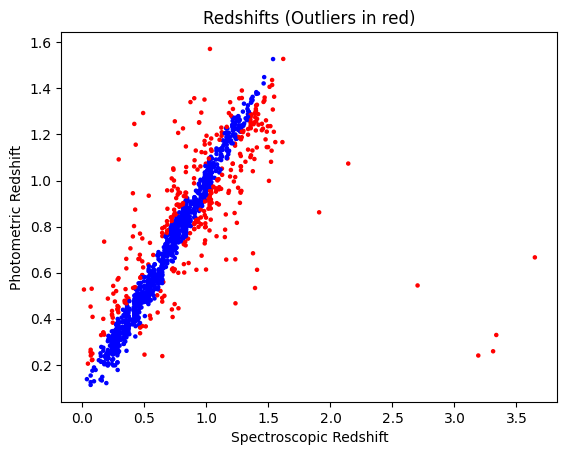

In [5]:
import matplotlib.pyplot as plt
from matplotlib import colors

redshift_data = {'Spectral Redshift': y_test['zhelio'],
                 'Photo Redshift': rf_model.predict(X_test)}
redshift_df = pd.DataFrame(data = redshift_data)
redshift_df['Outliers'] = np.abs(redshift_df['Photo Redshift'] - redshift_df['Spectral Redshift']) > 0.15/(1.0 + redshift_df['Spectral Redshift'])

plt.scatter(redshift_df['Spectral Redshift'], redshift_df['Photo Redshift'], s=5, 
            c=redshift_df['Outliers'], cmap='bwr')
plt.xlabel('Spectroscopic Redshift')
plt.ylabel('Photometric Redshift')
plt.title('Redshifts (Outliers in red)')
plt.show()

In [6]:
outlier_count = len(redshift_df[redshift_df['Outliers']==True])
print(f"Number of outliers: {outlier_count}")
outlier_fraction = outlier_count / len(redshift_df['Outliers'])
print(f"Fraction of data that is outlier: {outlier_fraction}")

Number of outliers: 354
Fraction of data that is outlier: 0.24098025867937373


(d) Let's try to optimize hyperparameters `max_features` and `n_estimators`. For `max_features`, try three different values: None, "sqrt", and 2. Compute the test scores of the best model and compare them with what you got in #b. (1 pt)

In [7]:
from sklearn.model_selection import GridSearchCV

param_grid = {'max_features': [None, 'sqrt', 2],
              'n_estimators': [10, 20, 50, 100]}

grid_search = GridSearchCV(RandomForestRegressor(), param_grid, cv=5, return_train_score=True)
grid_search.fit(X_train, y_train)

print(f"Test score: {grid_search.score(X_test, y_test)}")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best model: {grid_search.best_estimator_}")

C:\Users\rlosacco\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\rlosacco\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\rlosacco\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

Test score: 0.686296140134785
Best parameters: {'max_features': None, 'n_estimators': 100}
Best model: RandomForestRegressor(max_features=None)


Test score = 0.69

-Rachel

(e) You might have found that the test scores are not drastically improved. What should we do? Let's try to add u-g, g-r, r-i, i-z, z-y colors and see if it improves the performance. You now have a 11-dimensional dataset. Using this new dataset, make a Random Forest, optimize hyperparameters, and compute the test score of the best model. (1 pt)

In [8]:
# ['u_apercor', 'g_apercor', 'r_apercor', 'i_apercor', 'z_apercor', 'y_apercor']
X['u-g'] = X['u_apercor'] - X['g_apercor']
X['g-r'] = X['g_apercor'] - X['r_apercor']
X['r-i'] = X['r_apercor'] - X['i_apercor']
X['i-z'] = X['i_apercor'] - X['z_apercor']
X['z-y'] = X['z_apercor'] - X['y_apercor']
X

C:\Users\rlosacco\AppData\Local\Temp\ipykernel_30716\726521950.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['u-g'] = X['u_apercor'] - X['g_apercor']
C:\Users\rlosacco\AppData\Local\Temp\ipykernel_30716\726521950.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['g-r'] = X['g_apercor'] - X['r_apercor']
C:\Users\rlosacco\AppData\Local\Temp\ipykernel_30716\726521950.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

,u_apercor,g_apercor,r_apercor,i_apercor,z_apercor,y_apercor,u-g,g-r,r-i,i-z,z-y
2499,25.549179,25.015547,24.127680,23.627111,23.415047,23.218842,0.533631,0.887867,0.500569,0.212064,0.196205
2502,23.634108,23.232950,22.791572,22.007964,21.743251,22.144828,0.401158,0.441378,0.783608,0.264712,-0.401577
2505,24.257617,23.818442,23.140150,22.879894,22.776113,22.804502,0.439176,0.678292,0.260255,0.103781,-0.028390
2509,24.052749,22.271815,20.874739,20.284793,20.029217,19.790933,1.780934,1.397075,0.589946,0.255576,0.238284
2510,24.772632,24.679911,24.632732,24.182331,23.918161,23.882785,0.092721,0.047179,0.450401,0.264169,0.035376
...,...,...,...,...,...,...,...,...,...,...,...
19949,24.455093,24.275983,24.233811,24.109624,23.809521,23.389464,0.179110,0.042172,0.124187,0.300103,0.420057
20131,23.461026,23.007713,22.359102,21.553143,20.946282,20.972074,0.453313,0.648611,0.805959,0.606860,-0.025792
20134,24.615031,22.985132,21.601458,21.027322,20.732666,20.588093,1.629899,1.383674,0.574136,0.294656,0.144573
20135,22.611269,22.080842,21.404755,21.188319,20.962956,20.998884,0.530427,0.676087,0.216437,0.225363,-0.035928


In [9]:
# grid search again with more features

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

param_grid = {'max_features': [None, 'sqrt', 2],
              'n_estimators': [10, 20, 50, 100]}

grid_search = GridSearchCV(RandomForestRegressor(), param_grid, cv=5, return_train_score=True)
grid_search.fit(X_train, y_train)

print(f"Test score: {grid_search.score(X_test, y_test)}")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best model: {grid_search.best_estimator_}")

C:\Users\rlosacco\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\rlosacco\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\rlosacco\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

Test score: 0.7479068361022463
Best parameters: {'max_features': 'sqrt', 'n_estimators': 100}
Best model: RandomForestRegressor(max_features='sqrt')


Test score: 0.76

-Rachel

(f) With your best model, repeat #c. Make a plot showing photometric redshift vs. spectroscopic redshift, and compute the outlier fraction. Do you find better perfomance? (1 pt)

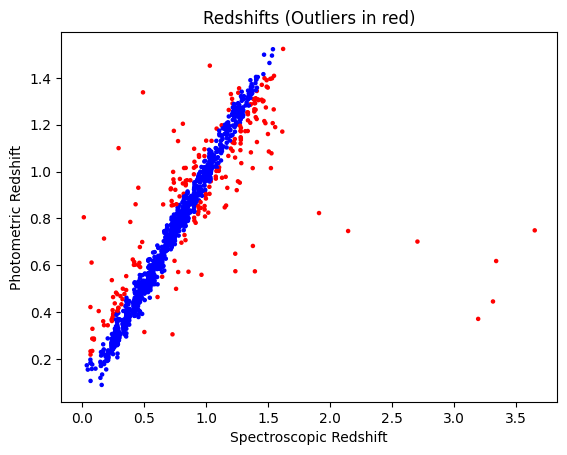

In [10]:
optimal_forest = grid_search.best_estimator_

redshift_data = {'Spectral Redshift': y_test['zhelio'],
                 'Photo Redshift': optimal_forest.predict(X_test)}
redshift_df = pd.DataFrame(data = redshift_data)
redshift_df['Outliers'] = np.abs(redshift_df['Photo Redshift'] - redshift_df['Spectral Redshift']) > 0.15/(1.0 + redshift_df['Spectral Redshift'])

plt.scatter(redshift_df['Spectral Redshift'], redshift_df['Photo Redshift'], s=5, 
            c=redshift_df['Outliers'], cmap='bwr')
plt.xlabel('Spectroscopic Redshift')
plt.ylabel('Photometric Redshift')
plt.title('Redshifts (Outliers in red)')
plt.show()

In [11]:
outlier_count = len(redshift_df[redshift_df['Outliers']==True])
print(f"Number of outliers: {outlier_count}")
outlier_fraction = outlier_count / len(redshift_df['Outliers'])
print(f"Fraction of data that is outlier: {outlier_fraction}")

Number of outliers: 219
Fraction of data that is outlier: 0.14908100748808714


14% outliers vs. 25% outliers previously

-Rachel

(g) Make a plot showing feature importance. Which is more important between colors and magnitudes? Does the feature importance plot support that adding colors helped improve the performance? (1 pt)

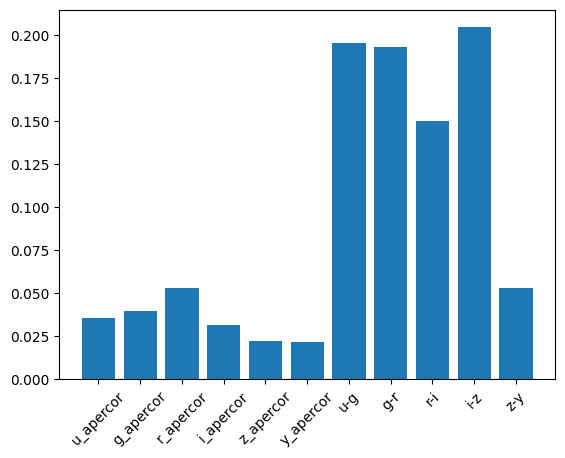

In [12]:
feature_names = X.columns
feature_importances = optimal_forest.feature_importances_
plt.bar(feature_names, feature_importances)
plt.xticks(rotation=45)
plt.show()

The colors are an order of magnitude more important, and should definitely be included in this analysis.

-Rachel

### 2. Photometric redshift estimator using Gradient Boosting (3 pts)


This time, let's use Gradient Boosting to compute photometric redshift. 

(a) Let's use `max_depth=2`. What `n_estimator` should we use? Make a plot showing the validation error vs. n_estimator and find the optimal `n_estimator`. What is your optimal `n_estimator` and what is the test score using the optimal model? (1 pt)

In [13]:
import sklearn
sklearn.__version__

'1.3.0'

In [25]:
from sklearn.ensemble import GradientBoostingRegressor

estimators = list(range(200, 600, 25))
print(estimators)
max_depth = 2
scores = []

for i, n in enumerate(estimators):
    gbr = GradientBoostingRegressor(max_depth=max_depth, n_estimators=n)
    model = gbr.fit(X_train, y_train)
    scores.append(gbr.score(X_test, y_test))

print(scores)

[200, 225, 250, 275, 300, 325, 350, 375, 400, 425, 450, 475, 500, 525, 550, 575]


C:\Users\rlosacco\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\rlosacco\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\rlosacco\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (

[0.7421036018019898, 0.7468349386632913, 0.7501501112325846, 0.7506897632182525, 0.753843284648013, 0.7561100117509003, 0.7597791761551382, 0.7618465023616279, 0.7651632014376422, 0.7661948977923589, 0.7703073221913292, 0.7700832702975403, 0.7707026689033787, 0.7713289243241341, 0.7712694134099845, 0.7731200783103046]


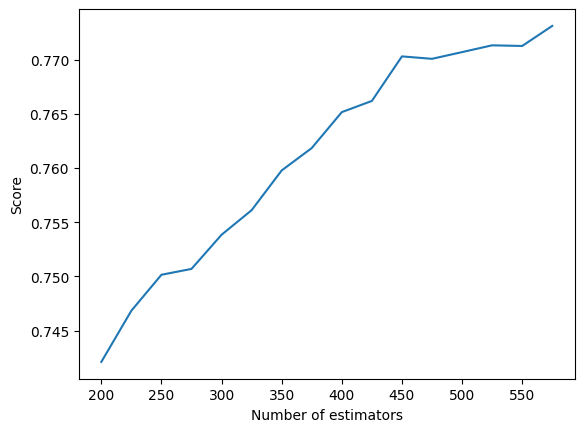

In [26]:
plt.plot(estimators, scores)
plt.xlabel('Number of estimators')
plt.ylabel('Score')
plt.show()

(b) Using the `GradientBoostingRegressor` you built in #a, make predictions for the test dataset. This prediction will be the "photometric redshift". Then, make a scatter plot showing photometric redshift vs. spectroscopic redshift. Your figure should look similar to Figure 5 of Zhou et al. (2019). Also, compute the outlier fraction $\eta$, which is defined as the fraction of objects with $|z_{phot}-z_{spec}| > 0.15/(1+z_{spec})$. (1 pt)

C:\Users\rlosacco\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


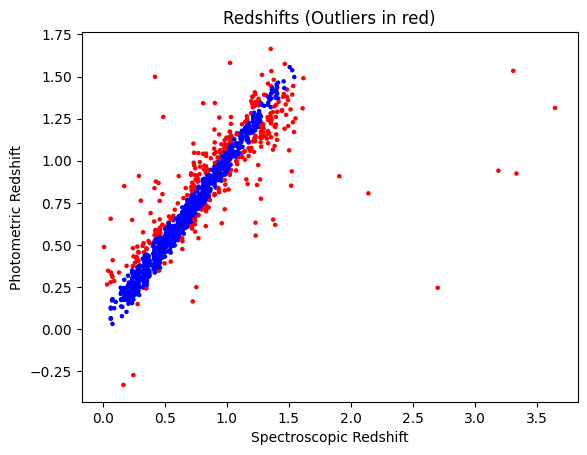

In [28]:
gbr_best = GradientBoostingRegressor(max_depth=2, n_estimators=600)
gbr_model = gbr_best.fit(X_train, y_train)

redshift_data = {'Spectral Redshift': y_test['zhelio'],
                 'Photo Redshift': gbr_model.predict(X_test)}
redshift_df = pd.DataFrame(data = redshift_data)
redshift_df['Outliers'] = np.abs(redshift_df['Photo Redshift'] - redshift_df['Spectral Redshift']) > 0.15/(1.0 + redshift_df['Spectral Redshift'])

plt.scatter(redshift_df['Spectral Redshift'], redshift_df['Photo Redshift'], s=5, 
            c=redshift_df['Outliers'], cmap='bwr')
plt.xlabel('Spectroscopic Redshift')
plt.ylabel('Photometric Redshift')
plt.title('Redshifts (Outliers in red)')
plt.show()

In [29]:
outlier_count = len(redshift_df[redshift_df['Outliers']==True])
print(f"Number of outliers: {outlier_count}")
outlier_fraction = outlier_count / len(redshift_df['Outliers'])
print(f"Fraction of data that is outlier: {outlier_fraction}")

Number of outliers: 344
Fraction of data that is outlier: 0.23417290673927843


(c) Make a movie showing the evolution of photometric redshift vs. spectroscopic redshift as you increase `n_estimator`. See gbr.mp4 on Canvas as an example. Discuss what you see in the movie in the context of boosting. Submit your movie file. (1 pt)

No

-Rachel

### Congratulations! You reproduced results presented in yet another journal paper. If you enjoyed the homework and would like to do some additional related analysis, I recommend you have a look at the following papers and references therein. Feel free to read/reproduce them for paper presentation and/or term project.

https://ui.adsabs.harvard.edu/abs/2010ApJ...712..511C/abstract

https://ui.adsabs.harvard.edu/abs/2021MNRAS.505.4847H/abstract

https://ui.adsabs.harvard.edu/abs/2022MNRAS.509.2289L/abstract

https://ui.adsabs.harvard.edu/abs/2022MNRAS.512.1696H/abstract